In [1]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import skew, kurtosis, median_absolute_deviation
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)
import matplotlib.pyplot as plt
data_dir = '../../../data/'

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 54.6min finished


------------------------------
18673
------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


Training fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000468495	training's RMSPE: 0.216987	valid_1's rmse: 0.000501516	valid_1's RMSPE: 0.231417
[100]	training's rmse: 0.000449203	training's RMSPE: 0.208051	valid_1's rmse: 0.000499811	valid_1's RMSPE: 0.23063
Early stopping, best iteration is:
[80]	training's rmse: 0.000455831	training's RMSPE: 0.211121	valid_1's rmse: 0.000499225	valid_1's RMSPE: 0.23036
Training fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000469547	training's RMSPE: 0.217197	valid_1's rmse: 0.000496566	valid_1's RMSPE: 0.230304
[100]	training's rmse: 0.000450139	training's RMSPE: 0.208219	valid_1's rmse: 0.000494911	valid_1's RMSPE: 0.229536
[150]	training's rmse: 0.000436762	training's RMSPE: 0.202032	valid_1's rmse: 0.00049516	valid_1's RMSPE: 0.229652
Early stopping, best iteration is:
[138]	training's rmse: 0.000439704	training's RMSPE: 0.203393	valid_1's rmse: 0.000494

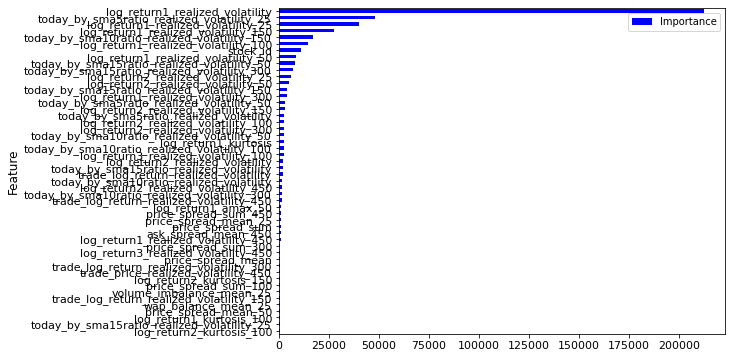

In [6]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2']+ df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))
# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv(data_dir + 'train.csv')
    test = pd.read_csv(data_dir + 'test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return).fillna(0)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return).fillna(0)
    df['log_return3'] = df.groupby(['time_id'])['wap2'].apply(log_return).fillna(0)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # ryotaro_feature
    for i in [5,10,15,50,100,150,300,450]:
        df['sma'+str(i)] = df.groupby(by=['time_id'])['wap1'].transform(lambda x:  x.rolling(i, center=False).mean())
     
    for i in [5,10,15,50,100,150,300,450]:
        df['today_by_sma'+str(i)+'ratio']= df['wap1']/df['sma'+str(i)]
        df['today_by_sma'+str(i)+'ratio'] = df.groupby(by = ['time_id'])['today_by_sma'+str(i)+'ratio'].apply(log_return).fillna(0)
      
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'wap2': [np.sum, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'wap3': [np.sum, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'log_return3': [np.sum, realized_volatility, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'ask_price1':[np.sum, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'ask_price2':[np.sum, np.mean, np.std,np.max, median_absolute_deviation,skew,kurtosis],
        'bid_price1':[np.sum, np.mean, np.std, median_absolute_deviation,skew,kurtosis],
        'bid_price2':[np.sum, np.mean, np.std, median_absolute_deviation,skew,kurtosis],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        'today_by_sma5ratio': [np.sum, realized_volatility, np.mean, np.std],
        'today_by_sma10ratio': [np.sum, realized_volatility, np.mean, np.std],
        'today_by_sma15ratio': [np.sum, realized_volatility, np.mean, np.std],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature


    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    df_feature_100 = get_stats_window(seconds_in_bucket = 100, add_suffix = True)
    df_feature_50 = get_stats_window(seconds_in_bucket = 50, add_suffix = True)
    df_feature_25 = get_stats_window(seconds_in_bucket = 25, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    df_feature = df_feature.merge(df_feature_50, how = 'left', left_on = 'time_id_', right_on = 'time_id__50')
    df_feature = df_feature.merge(df_feature_25, how = 'left', left_on = 'time_id_', right_on = 'time_id__25')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150', 'time_id__100', 'time_id__50', 'time_id__25'], axis = 1, inplace = True)# Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
 
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return).fillna(0)

    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'price':[realized_volatility,np.std, median_absolute_deviation],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature



# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
# Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'num_leaves': 100,
      'n_jobs': -1,
      'learning_rate': 0.1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'verbose': -1
    }
    

    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
#     x = x[feature]
    y = train['target']
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
#     x_test = x_test[feature]
    
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)

    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 5
        rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': model.feature_importance(importance_type='gain')})
    importances.sort_values(by = 'Importance', inplace=True)
  
    
    importances2 = importances.nlargest(100,'Importance', keep='first').sort_values(by='Importance', ascending=True)
    print(importances2)
    list_sample = importances2['Feature'].to_list()
    print(list_sample)
#     importances2.to_csv('Feature.csv',index = False)

    importances4 = importances.nlargest(100,'Importance', keep='first').sort_values(by='Importance')
    print('特徴量弱い順')
    print(importances4)
    
    
    
    importances3 = importances.nlargest(50,'Importance', keep='first').sort_values(by='Importance', ascending=True)
    list_sample = importances3['Feature'].to_list()
    print(list_sample)
    
    
    importances3[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)
        # Return test predictions
    return test_predictions

# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')
train.to_csv('train.csv',index = False)
print('-'*30)
print(train.isna().sum().sum())
print('-'*30)
# print(train)

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Traing and evaluate
test_predictions = train_and_evaluate(train, test)
# Save test predictions
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [7]:
train.columns[train.isna().sum() > 0]

Index(['wap1_std_450', 'wap2_std_450', 'wap3_std_450', 'log_return1_std_450',
       'log_return2_std_450', 'log_return3_std_450', 'wap_balance_std_450',
       'price_spread_std_450', 'bid_spread_std_450', 'ask_spread_std_450',
       'ask_price1_std_450', 'ask_price2_std_450', 'bid_price1_std_450',
       'bid_price2_std_450', 'total_volume_std_450',
       'volume_imbalance_std_450', 'today_by_sma5ratio_std_450',
       'today_by_sma10ratio_std_450', 'today_by_sma15ratio_std_450',
       'trade_log_return_realized_volatility',
       'trade_price_realized_volatility', 'trade_price_std',
       'trade_price_median_absolute_deviation',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_450',
       'trade_price_realized_volatility_450', 'trade_price_std_450',
       'trade_price_median_absolute_deviation_450',
       'trade_seconds_in_bucket_count_unique_450', 'trade_size_sum_450',
       'trade_order

In [5]:
train.isna().sum().sum()

3879061